In [13]:
import gradio as gr
from text_generator import MistralGenerator
from image_generator import LlavaGenerator

In [3]:
from text_generator import MultimodalAnswerPipeline

In [4]:
import os
from tqdm.auto import tqdm

## Config Mistral

In [15]:
BASE_URL = os.getenv('REMOTE_URL')
# BASE_URL = os.getenv('LOCAL_URL')
PROMPT_TEMPLATE = """You are a knowledgeable assistant. Use the following retrieved context to answer the user's question as accurately as possible.

Context:
{context}

Question:
{question}

Instructions:
- Use only the information provided in the context to answer.
- Do not make up information or assumptions.
- If the answer is not in the context, respond with "The answer is not available in the provided context."
- Provide a concise and clear answer.

Answer: Short answer
Answered or not : Yes(answered)/No(cannot answer)
Reason for answer : Reason for the answer
"""

API_KEY = os.getenv('API_KEY')

# Load data and generator
text_gen = MistralGenerator(base_url=BASE_URL,prompt_template=PROMPT_TEMPLATE )

In [14]:
response = text_gen.generate_answer("who are you", "you are a star")
extract_reason(response)

'The context suggests that you are compared to a star, but it does not provide information about your identity. Therefore, based on the given context, I can conclude that you are symbolically or metaphorically a star, but no specific person or entity is identified.'

## Config LLava

In [16]:
BASE_URL = os.getenv('LOCAL_URL')
API_KEY = "lm-studio"
# Vision RAG prompt
vision_prompt = """<image>

Use the image provided to answer the question as accurately as possible.

Question: <question>

Answer:"""

vision_gen = LlavaGenerator(base_url=BASE_URL,api_key=API_KEY,prompt_template=vision_prompt)

In [27]:
mistral_gen = MistralGenerator(model="mistral-instruct-7b@q4_k_m",base_url=os.getenv('REMOTE_URL'))
llava_gen = LlavaGenerator(model="llava-v1.5-7b@q5_k_m",base_url=os.getenv('LOCAL_URL'))

pipeline = MultimodalAnswerPipeline(mistral=mistral_gen, llava=llava_gen)

# Functions Defining for Gradio

In [18]:
import re

def extract_reason(response):
    # Find the reason part after "Reason for answer:"
    match = re.search(r'Reason for answer:\s*(.*)', response, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return response.strip()  # fallback to full text if pattern not found

In [28]:
# Define functions for Gradio
def generate_text_response(question, context):
    try:
        return text_gen.generate_answer(question =question, context=context)
    except Exception as e:
        return e
        
def generate_image_response(image_path, question):
    try:
        return vision_gen.generate_answer(image_path, question)
    except Exception as e:
        return e
    
def custom_pipeline(image_path, question, context):
    try:
        return pipeline.answer_question(question, context, image_path)
    except Exception as e:
        return e

In [ ]:
# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        with gr.TabItem("Text Generator"):
            question_input_text = gr.Textbox(label="Question")
            context_input = gr.Textbox(label="Context", lines=4)
            text_output = gr.Textbox(label="Answer")
            text_button = gr.Button("Generate Answer")
            text_button.click(generate_text_response, [question_input_text, context_input], text_output)

        with gr.TabItem("Vision Generator"):
            image_input = gr.Image(type="pil")
            question_input_img = gr.Textbox(label="Question")
            image_output = gr.Textbox(label="Answer")
            image_button = gr.Button("Generate Answer")
            image_button.click(generate_image_response, [image_input, question_input_img], image_output)

        with gr.TabItem("Custom Pipeline"):
            image_input_custom = gr.Image(type="pil")
            question_input_custom = gr.Textbox(label="Question")
            context_input_custom = gr.Textbox(label="Context", lines=4)
            combined_output = gr.Textbox(label="Combined Answer")
            custom_button = gr.Button("Run Pipeline")
            custom_button.click(custom_pipeline, [image_input_custom, question_input_custom, context_input_custom], combined_output)

# Launch app
demo.launch()

## Load the dataset - for asking questions and loading ground truth

In [7]:
import pandas as pd
from PIL import Image

# Load dataset
DATASET_PATH = "../Data/VisDoM-main/spiqa/spiqa.csv"
IMAGE_FOLDER = "../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
df = pd.read_csv(DATASET_PATH)
id_list = df["q_id"].astype(str).tolist()

In [8]:
df.head(2)

,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...
1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...


In [35]:
def load_entry_by_id(selected_id):
    row = df[df["q_id"].astype(str) == selected_id].iloc[0]
    question = row["old_question"]
    context = row.get("caption", "")
    answer = row["answer"]
    image_path = IMAGE_FOLDER+"/"+row.get("doc_id", None)+"/"+row.get("reference_figure", None)

    image_display = None
    full_image_path = None
    if pd.notna(image_path):
        full_image_path = os.path.join(IMAGE_FOLDER, image_path)
        if os.path.exists(full_image_path):
            image_display = Image.open(full_image_path)

    # Generate real outputs using the functions
    text_output = text_gen.generate_answer(question, context)
    vision_output = vision_gen.generate_answer(full_image_path, question) if full_image_path else "[No image available]"
    custom_text = text_gen.generate_answer(question, context)
    custom_output = f"Text Generator Answer:\n{custom_text}\n\nVision Generator Answer:\n{vision_output}"
    print(text_output, vision_output, custom_text, custom_output)
    return question, context, answer, image_display, text_output, vision_output, custom_output

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        # with gr.TabItem("Text Generator"):
        #     question_input_text = gr.Textbox(label="Question")
        #     context_input = gr.Textbox(label="Context", lines=4)
        #     text_output = gr.Textbox(label="Answer")
        #     text_button = gr.Button("Generate Answer")
        #     text_button.click(generate_text_response, [question_input_text, context_input], text_output)

        # with gr.TabItem("Vision Generator"):
        #     image_input = gr.Image(type="pil")
        #     question_input_img = gr.Textbox(label="Question")
        #     image_output = gr.Textbox(label="Answer")
        #     image_button = gr.Button("Generate Answer")
        #     image_button.click(generate_image_response, [image_input, question_input_img], image_output)

        # with gr.TabItem("Custom Pipeline"):
        #     image_input_custom = gr.Image(type="pil")
        #     question_input_custom = gr.Textbox(label="Question")
        #     context_input_custom = gr.Textbox(label="Context", lines=4)
        #     combined_output = gr.Textbox(label="Combined Answer")
        #     custom_button = gr.Button("Run Pipeline")
        #     custom_button.click(custom_pipeline, [image_input_custom, question_input_custom, context_input_custom], combined_output)

        with gr.TabItem("Dataset Viewer"):
            dropdown_id = gr.Dropdown(choices=id_list, label="Select Example ID")
            text_button = gr.Button("Generate Answer")
            display_question = gr.Textbox(label="Question", interactive=False)
            display_context = gr.Textbox(label="Caption", interactive=False)
            display_answer = gr.Textbox(label="Gold Answer", interactive=False)
            display_image = gr.Image(label="Image", type="pil")
            display_text_gen = gr.Textbox(label="Text Generator Output", interactive=False)
            display_vision_gen = gr.Textbox(label="Vision Generator Output", interactive=False)
            display_custom_gen = gr.Textbox(label="Custom Pipeline Output", interactive=False)
            text_button.click(fn=load_entry_by_id, inputs=dropdown_id,
                               outputs=[display_question, display_context, display_answer,
                                        display_image, display_text_gen, display_vision_gen,
                                        display_custom_gen])

# Launch app
demo.launch()


* Running on local URL:  http://127.0.0.1:7896

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpx\_transports\default.py", line 101, in map_httpcore_exceptions
    yield
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpx\_transports\default.py", line 250, in handle_request
    resp = self._pool.handle_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpcore\_sync\connection_pool.py", line 256, in handle_request
    raise exc from None
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpcore\_sync\connection_pool.py", line 236, in handle_request
    response = connection.handle_request(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpcore\_sync\connection.py", line 101, in handle_request
    raise exc
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\httpcore\_sync\connection.py", line 78, in handle_r

# All three in one dashboard

In [29]:
df["q_id"] = df["q_id"].astype(str)
id_list = df["q_id"].tolist()

# Define function to display dataset row without model calls
def load_entry_by_id(selected_id):
    row = df[df["q_id"] == selected_id].iloc[0]
    question = row["old_question"]
    context = row.get("caption", "")
    answer = row["answer"]
    image_path = row.get("doc_id", None)+"/"+row.get("reference_figure", None)

    if pd.notna(image_path):
        full_image_path = os.path.join(IMAGE_FOLDER, image_path)
        if os.path.exists(full_image_path):
            # image_display = Image.new("RGB", (100, 100), color="red")
            image_display = Image.open(full_image_path).convert("RGB")
            # print("Loaded image type:", type(image_display))
            
        text_out = generate_text_response(question, context)
        vision_out = generate_image_response(full_image_path, question)
        custom_out = custom_pipeline(question, context, full_image_path)

    return question, context, answer, image_display,text_out, vision_out, custom_out

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        with gr.TabItem("Dataset Viewer"):
            dropdown_id = gr.Dropdown(choices=id_list, label="Select Example ID")
            text_button = gr.Button("Generate Answer")
            display_question = gr.Textbox(label="Question", interactive=False)
            display_context = gr.Textbox(label="Caption", interactive=False)
            display_answer = gr.Textbox(label="Gold Answer", interactive=False)
            display_image = gr.Image(label="Image")
            display_text_gen = gr.Textbox(label="Text Generator Output", interactive=False)
            display_vision_gen = gr.Textbox(label="Vision Generator Output", interactive=False)
            display_custom_gen = gr.Textbox(label="Custom Pipeline Output", interactive=False)

            text_button.click(fn=load_entry_by_id, inputs=dropdown_id,
                               outputs=[display_question, display_context, display_answer, display_image,
                                         display_text_gen, display_vision_gen, display_custom_gen])
            
# Launch app
demo.launch()

* Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.


In [24]:
# from eval_metrics_utils import evaluate_single_vqa_instance
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Step 1: Your input
from eval_metrics_utils import evaluate_single_vqa_instance


ground_truth = "yellow"
predictions = {
    "text_only": "yellow color",
    "vision_only": "red",
    "custom": "It is yellow."
}

# Step 2: Evaluate predictions
results = evaluate_single_vqa_instance(
    ground_truth=ground_truth,
    predictions=predictions,
    plot=False  # we'll plot manually
)

In [ ]:
# Step 3: Radar Chart Plotting Function
def plot_radar_comparison(results_dict):
    metrics = list(next(iter(results_dict.values())).keys())
    pipelines = list(results_dict.keys())

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for name in pipelines:
        scores = list(results_dict[name].values())
        scores += scores[:1]
        ax.plot(angles, scores, label=name, marker='o')
        ax.fill(angles, scores, alpha=0.1)

    ax.set_title("Comparison of VQA Pipelines (Radar Chart)", size=13)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

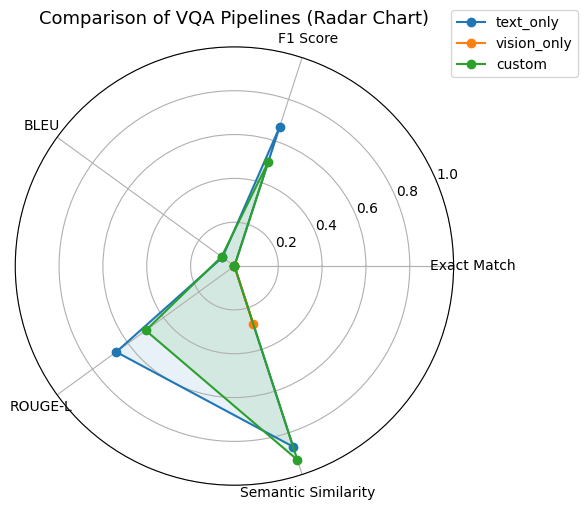

In [79]:
# Step 4: Show the radar chart
plot_radar_comparison(results)

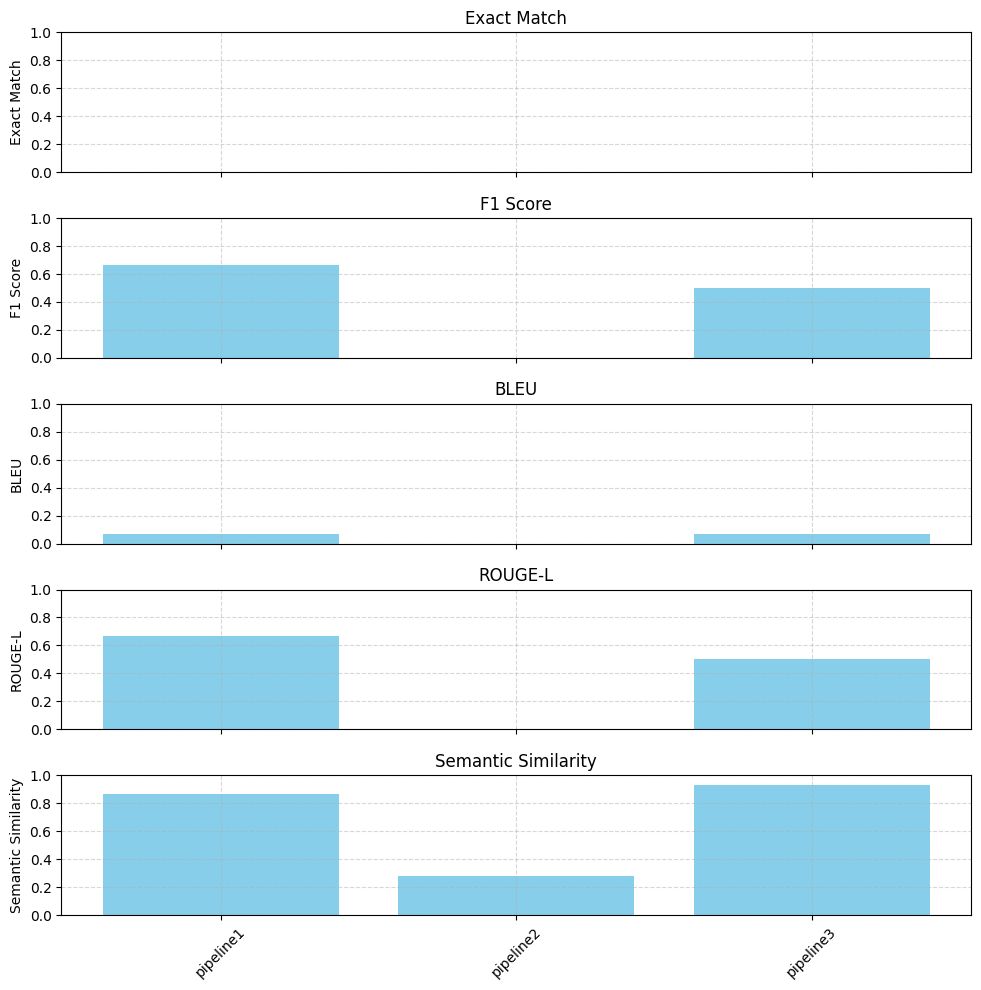

{'pipeline1': {'Exact Match': 0.0,
  'F1 Score': 0.6666666666666666,
  'BLEU': 0.06754436142034707,
  'ROUGE-L': 0.6666666666666666,
  'Semantic Similarity': 0.8665945529937744},
 'pipeline2': {'Exact Match': 0.0,
  'F1 Score': 0.0,
  'BLEU': 0,
  'ROUGE-L': 0.0,
  'Semantic Similarity': 0.27946367859840393},
 'pipeline3': {'Exact Match': 0.0,
  'F1 Score': 0.5,
  'BLEU': 0.07249749990681824,
  'ROUGE-L': 0.5,
  'Semantic Similarity': 0.9298678636550903}}

In [80]:
# from vqa_eval_utils import evaluate_single_vqa_instance

evaluate_single_vqa_instance(
    ground_truth="yellow",
    predictions={
        "pipeline1": "yellow color",
        "pipeline2": "red",
        "pipeline3": "It is yellow."
    },
    plot=True  # <-- auto shows per-metric bar charts
)


---